# Preprocessing

In [56]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
from sklearn.svm import SVC
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Combine Genomic Data and Clinic Data

In [21]:
input_file = 'drive/MyDrive/MSK/gene_modified.csv'
gene = pd.read_table(input_file, sep=',')
gene.head()

,sample_id,1,2,3,4,5,7,8,11,12,...,20522,20523,20524,20525,20526,20527,20528,20529,20530,20531
0,TCGA-3L-AA1B-01,0.7981,1.6905,1.9068,0.7458,0.3572,4.9963,2.5034,-0.5022,1.5585,...,1.2458,0.1254,1.5265,1.9041,2.1862,0.5758,-1.7449,1.2799,-2.3005,2.1609
1,TCGA-4N-A93T-01,-5.5534,-0.2648,-0.4676,0.7168,2.4251,5.4312,-0.6054,-2.4195,1.5595,...,-1.4338,-0.7270,-0.6711,0.7206,2.4134,-1.1532,-3.9237,0.6431,-2.5295,-2.0323
2,TCGA-4T-AA8H-01,-5.5534,0.8189,1.2713,0.7258,1.0227,3.8785,3.8294,-2.4195,1.9697,...,2.1326,1.3208,-1.5396,0.4724,2.0699,-1.7828,-1.0130,0.5523,-0.6071,0.1905
3,TCGA-5M-AAT4-01,-5.5534,0.5066,2.2447,0.7753,2.8010,4.5983,2.8292,-2.4195,1.3171,...,1.7637,2.4208,0.5327,2.7372,3.4521,-1.2117,-2.4370,0.4180,-2.7636,0.5772
4,TCGA-5M-AAT5-01,-5.5534,1.1235,2.4542,2.1804,2.8737,3.7993,0.7311,-2.4195,4.7231,...,2.9761,0.8180,-1.8164,1.5215,2.8586,0.6037,-1.6973,0.2519,-2.9194,-1.0094


In [22]:
gene['PATIENT_ID'] = gene['sample_id'].str[:12]
gene.drop('sample_id', axis =1, inplace = True)
gene.head()

,1,2,3,4,5,7,8,11,12,13,...,20523,20524,20525,20526,20527,20528,20529,20530,20531,PATIENT_ID
0,0.7981,1.6905,1.9068,0.7458,0.3572,4.9963,2.5034,-0.5022,1.5585,-1.1044,...,0.1254,1.5265,1.9041,2.1862,0.5758,-1.7449,1.2799,-2.3005,2.1609,TCGA-3L-AA1B
1,-5.5534,-0.2648,-0.4676,0.7168,2.4251,5.4312,-0.6054,-2.4195,1.5595,-1.1035,...,-0.7270,-0.6711,0.7206,2.4134,-1.1532,-3.9237,0.6431,-2.5295,-2.0323,TCGA-4N-A93T
2,-5.5534,0.8189,1.2713,0.7258,1.0227,3.8785,3.8294,-2.4195,1.9697,-0.6859,...,1.3208,-1.5396,0.4724,2.0699,-1.7828,-1.0130,0.5523,-0.6071,0.1905,TCGA-4T-AA8H
3,-5.5534,0.5066,2.2447,0.7753,2.8010,4.5983,2.8292,-2.4195,1.3171,-2.3649,...,2.4208,0.5327,2.7372,3.4521,-1.2117,-2.4370,0.4180,-2.7636,0.5772,TCGA-5M-AAT4
4,-5.5534,1.1235,2.4542,2.1804,2.8737,3.7993,0.7311,-2.4195,4.7231,-0.7863,...,0.8180,-1.8164,1.5215,2.8586,0.6037,-1.6973,0.2519,-2.9194,-1.0094,TCGA-5M-AAT5


In [23]:
input_file = 'drive/MyDrive/MSK/patient_dummies.csv'
patient = pd.read_table(input_file, sep=',')
patient.head()

,PATIENT_ID,OS_STATUS,OS_MONTHS,CANCER_TYPE_ACRONYM_COAD,CANCER_TYPE_ACRONYM_READ,SEX_Female,SEX_Male,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE I,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE IA,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE II,...,PERSON_NEOPLASM_CANCER_STATUS_With Tumor,PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT_No,PRIMARY_LYMPH_NODE_PRESENTATION_ASSESSMENT_Yes,PRIOR_DX_No,PRIOR_DX_Yes,"PRIOR_DX_Yes, History Of Synchronous And Or Bilateral Malignancy",IN_PANCANPATHWAYS_FREEZE_No,IN_PANCANPATHWAYS_FREEZE_Yes,AGE_bin_<65,AGE_bin_>=65
0,TCGA-3L-AA1B,0,15.616267,1,0,1,0,1,0,0,...,0,0,1,1,0,0,0,1,1,0
1,TCGA-4N-A93T,0,4.799947,1,0,0,1,0,0,0,...,1,0,1,1,0,0,0,1,1,0
2,TCGA-4T-AA8H,0,12.657396,1,0,1,0,0,0,0,...,0,0,1,1,0,0,0,1,1,0
3,TCGA-5M-AAT4,1,1.610941,1,0,0,1,0,0,0,...,1,0,1,1,0,0,0,1,0,1
4,TCGA-5M-AAT6,1,9.534142,1,0,1,0,0,0,0,...,1,0,1,1,0,0,0,1,1,0


In [24]:
columns = ['PATIENT_ID', 'OS_STATUS',	'OS_MONTHS', 'PATH_M_STAGE_M0', 'AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE IV', 'PATH_T_STAGE_T4', 'PATH_N_STAGE_N2', 'AGE_bin_>=65', 'PERSON_NEOPLASM_CANCER_STATUS_With Tumor', 'AGE_bin_<65', 'PERSON_NEOPLASM_CANCER_STATUS_Tumor Free', 'AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE I', 'AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE IIIC', 'PATH_T_STAGE_T4A', 'PATH_M_STAGE_M1B', 'ICD_10_C18.7', 'PATH_N_STAGE_N0', 'PATH_T_STAGE_T2', 'ICD_10_C18.2']
patient1 = patient[columns]

In [25]:
patient1.head()

,PATIENT_ID,OS_STATUS,OS_MONTHS,PATH_M_STAGE_M0,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE IV,PATH_T_STAGE_T4,PATH_N_STAGE_N2,AGE_bin_>=65,PERSON_NEOPLASM_CANCER_STATUS_With Tumor,AGE_bin_<65,PERSON_NEOPLASM_CANCER_STATUS_Tumor Free,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE I,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE IIIC,PATH_T_STAGE_T4A,PATH_M_STAGE_M1B,ICD_10_C18.7,PATH_N_STAGE_N0,PATH_T_STAGE_T2,ICD_10_C18.2
0,TCGA-3L-AA1B,0,15.616267,1,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0
1,TCGA-4N-A93T,0,4.799947,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1
2,TCGA-4T-AA8H,0,12.657396,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
3,TCGA-5M-AAT4,1,1.610941,0,1,0,0,1,1,0,0,0,0,0,1,0,1,0,1
4,TCGA-5M-AAT6,1,9.534142,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0,1


In [26]:
patient1['OS_STATUS'].dtype

dtype('int64')

In [27]:
comb = pd.merge(gene, patient1, on='PATIENT_ID')


In [28]:
comb.set_index('PATIENT_ID', inplace=True)

In [29]:
comb.rename(columns={"AGE_bin_<65": "AGE_less_65", "AGE_bin_>=65": "AGE_larger_65"}, inplace = True)

In [30]:
comb.head()

,1,2,3,4,5,7,8,11,12,13,...,AGE_less_65,PERSON_NEOPLASM_CANCER_STATUS_Tumor Free,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE I,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE IIIC,PATH_T_STAGE_T4A,PATH_M_STAGE_M1B,ICD_10_C18.7,PATH_N_STAGE_N0,PATH_T_STAGE_T2,ICD_10_C18.2
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
TCGA-3L-AA1B,0.7981,1.6905,1.9068,0.7458,0.3572,4.9963,2.5034,-0.5022,1.5585,-1.1044,...,1,1,1,0,0,0,0,1,1,0
TCGA-4N-A93T,-5.5534,-0.2648,-0.4676,0.7168,2.4251,5.4312,-0.6054,-2.4195,1.5595,-1.1035,...,1,0,0,0,1,0,0,0,0,1
TCGA-4T-AA8H,-5.5534,0.8189,1.2713,0.7258,1.0227,3.8785,3.8294,-2.4195,1.9697,-0.6859,...,1,1,0,0,0,0,0,1,0,0
TCGA-5M-AAT4,-5.5534,0.5066,2.2447,0.7753,2.8010,4.5983,2.8292,-2.4195,1.3171,-2.3649,...,0,0,0,0,0,1,0,1,0,1
TCGA-5M-AAT6,-5.5534,-0.4049,1.8196,1.8444,1.3267,2.9882,1.4178,1.6551,3.0239,-0.8844,...,1,0,0,0,1,0,0,0,0,1


In [31]:
! pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Classification Models (SVM & XGBoost)

## SVM

In [60]:
features = comb.drop(['OS_STATUS'], axis=1)
status = comb['OS_STATUS']

In [92]:
from sklearn.svm import SVC
train_f, test_f, train_s, test_s = train_test_split(features, status, test_size=0.33, random_state=0)

svm = SVC(probability=True)
svm.fit(train_f, train_s)

test_predict = svm.predict(test_f)

score = accuracy_score(test_s, test_predict)
print("Accuracy: %.2f%%" % (score * 100.0))

Accuracy: 84.28%


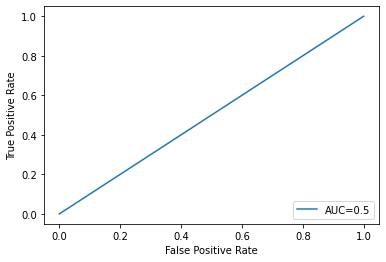

In [68]:
fpr, tpr, _ = metrics.roc_curve(test_s, test_predict)
auc = metrics.roc_auc_score(test_s, test_predict)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

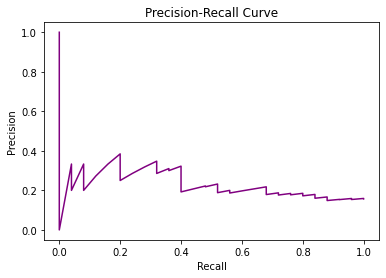

In [69]:
#Create PR Curve for Original Dataset
from sklearn.metrics import precision_recall_curve

y_score = svm.predict_proba(test_f)[:, 1]

precision, recall, thresholds = precision_recall_curve(test_s, y_score)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show() 

In [71]:
from sklearn.metrics import ConfusionMatrixDisplay

Confusion matrix, without normalization
[[134   0]
 [ 25   0]]
Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


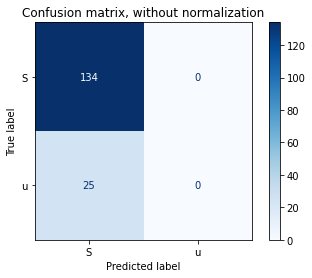

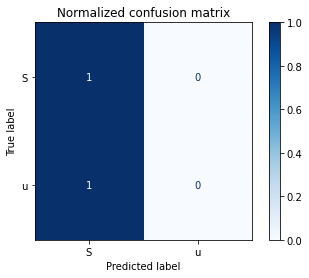

In [72]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svm,
        test_f,
        test_s,
        display_labels="Survival Status",
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

Rebalancing

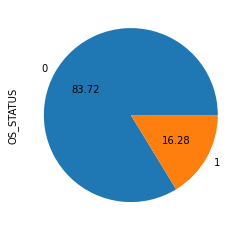

In [73]:
status.value_counts()
status.value_counts().plot.pie(autopct='%.2f')

Original dataset shape Counter({0: 401, 1: 78})
Resampled dataset shape Counter({1: 428, 0: 401})


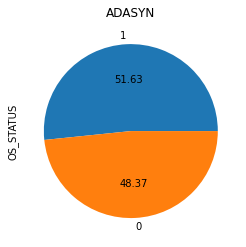

In [74]:
#ADASYN Oversampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN 

print('Original dataset shape %s' % Counter(status))
ada = ADASYN(random_state=42)
f_res, s_res = ada.fit_resample(features, status)
print('Resampled dataset shape %s' % Counter(s_res))

ax = s_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title('ADASYN')

In [75]:
#Concat rebalanced dataset
comb_new = pd.concat([f_res, s_res], axis=1)
comb_new.head()

,1,2,3,4,5,7,8,11,12,13,...,PERSON_NEOPLASM_CANCER_STATUS_Tumor Free,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE I,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE IIIC,PATH_T_STAGE_T4A,PATH_M_STAGE_M1B,ICD_10_C18.7,PATH_N_STAGE_N0,PATH_T_STAGE_T2,ICD_10_C18.2,OS_STATUS
0,0.7981,1.6905,1.9068,0.7458,0.3572,4.9963,2.5034,-0.5022,1.5585,-1.1044,...,1,1,0,0,0,0,1,1,0,0
1,-5.5534,-0.2648,-0.4676,0.7168,2.4251,5.4312,-0.6054,-2.4195,1.5595,-1.1035,...,0,0,0,1,0,0,0,0,1,0
2,-5.5534,0.8189,1.2713,0.7258,1.0227,3.8785,3.8294,-2.4195,1.9697,-0.6859,...,1,0,0,0,0,0,1,0,0,0
3,-5.5534,0.5066,2.2447,0.7753,2.8010,4.5983,2.8292,-2.4195,1.3171,-2.3649,...,0,0,0,0,1,0,1,0,1,1
4,-5.5534,-0.4049,1.8196,1.8444,1.3267,2.9882,1.4178,1.6551,3.0239,-0.8844,...,0,0,0,1,0,0,0,0,1,1


In [76]:
fn = comb_new.drop(['OS_STATUS'], axis=1)
sn = comb_new['OS_STATUS']

In [77]:
fn_train, fn_test, sn_train, sn_test = train_test_split(fn, sn, test_size=0.33, random_state=0)

In [80]:
svm.fit(fn_train, sn_train)

s_predict = svm.predict(fn_test)

Metrics

In [81]:
# accuracy 
score = accuracy_score(sn_test, s_predict)
print("Accuracy: %.2f%%" % (score * 100.0))

Accuracy: 54.01%


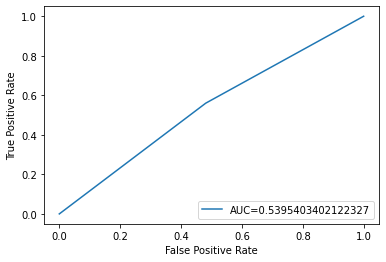

In [82]:
fpr, tpr, _ = metrics.roc_curve(sn_test, s_predict)
auc = metrics.roc_auc_score(sn_test, s_predict)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

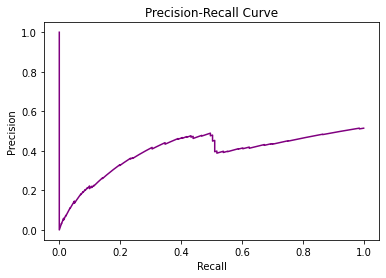

In [85]:
#Create PR Curve for Original Dataset
from sklearn.metrics import precision_recall_curve

sn_score = svm.predict_proba(fn_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(sn_test, sn_score)

fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

plt.show() 

Confusion matrix, without normalization
[[69 64]
 [62 79]]
Normalized confusion matrix
[[0.52 0.48]
 [0.44 0.56]]


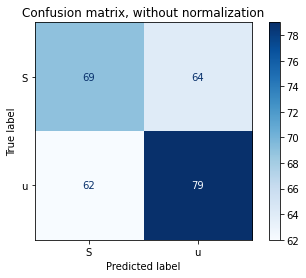

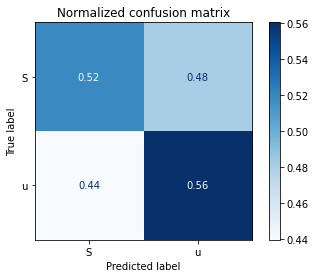

In [89]:
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svm,
        fn_test,
        sn_test,
        display_labels="Survival Status",
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [106]:
from sklearn import metrics
print('AUC: %.4f' % metrics.roc_auc_score(sn_test,s_predict))
print('ACC: %.4f' % metrics.accuracy_score(sn_test,s_predict))
print('Recall: %.4f' % metrics.recall_score(sn_test,s_predict))
print('F1-score: %.4f' %metrics.f1_score(sn_test,s_predict))
print('Precesion: %.4f' %metrics.precision_score(sn_test,s_predict))
metrics.confusion_matrix(sn_test,s_predict)

AUC: 0.5395
ACC: 0.5401
Recall: 0.5603
F1-score: 0.5563
Precesion: 0.5524


array([[69, 64],
       [62, 79]])

In [102]:
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
scaler = StandardScaler()
X_train = pca.fit_transform(fn_train)
X_test = pca.transform(fn_test)
X_train = scaler.fit_transform(fn_train)
X_test = scaler.transform(fn_test)

In [103]:
from IPython.core.formatters import SVGFormatter
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
def print_score(svm, X_train, sn_train, X_test, sn_test, train=True):
    if train:
        pred = svm.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: n {confusion_matrix(y_train, pred)}n")
    elif train==False:
        pred = SVGFormatter.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: n {confusion_matrix(y_test, pred)}n")

In [ ]:
# from sklearn.model_selection import GridSearchCV
# param_grid = {'C': [0.01, 0.1, 0.5, 1, 10, 100], 
#               'gamma': [1, 0.75, 0.5, 0.25, 0.1, 0.01, 0.001], 
#               'kernel': ['rbf', 'poly', 'linear']} 
# grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=1, cv=5)
# grid.fit(X_train, sn_train)
# best_params = grid.best_params_
# print(f"Best params: {best_params}")
# svm_clf = SVC(**best_params)
# svm_clf.fit(X_train, sn_train)
# print_score(svm_clf, X_train, sn_train, X_test, sn_test, train=True)
# print_score(svm_clf, X_train, sn_train, X_test, sn_test, train=False)

## XGBoost

In [32]:
xgb = XGBClassifier()

X = comb.drop(['OS_STATUS'], axis=1)
y = comb['OS_STATUS']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=7)

xgb.fit(X_train, y_train)

XGBClassifier()

metrics for dataset before rebalancing & feature selection

In [33]:
# accuracy 
from sklearn.metrics import accuracy_score
y_pred = xgb.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 86.16%


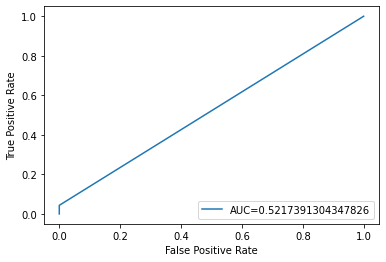

In [34]:
#roc curve
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred)
auc = metrics.roc_auc_score(y_test, y_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

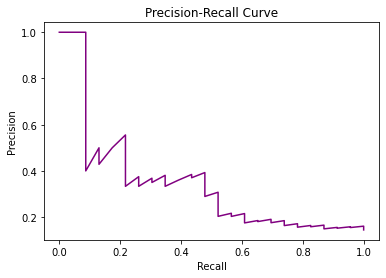

In [36]:
#Create PR Curve for Original Dataset
from sklearn.metrics import precision_recall_curve

y_score = xgb.predict_proba(X_test)[:, 1]
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(y_test, y_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show() 

In [38]:
#Create Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

confusionMatrix = confusion_matrix(y_test,y_pred)
ConfusionMatrixDisplay(confusionMatrix).plot()

ImportError: ignored

Rebalance Dataset

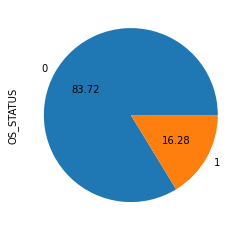

In [39]:
y.value_counts()
y.value_counts().plot.pie(autopct='%.2f')

Original dataset shape Counter({0: 401, 1: 78})
Resampled dataset shape Counter({1: 428, 0: 401})


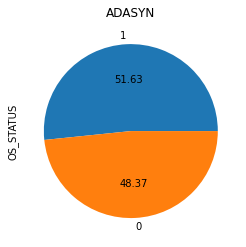

In [40]:
#ADASYN Oversampling
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import ADASYN 

print('Original dataset shape %s' % Counter(y))
ada = ADASYN(random_state=42)
X_res, y_res = ada.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

ax = y_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title('ADASYN')

In [41]:
#Concat rebalanced dataset
com_new = pd.concat([X_res, y_res], axis=1)
com_new.head()

,1,2,3,4,5,7,8,11,12,13,...,PERSON_NEOPLASM_CANCER_STATUS_Tumor Free,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE I,AJCC_PATHOLOGIC_TUMOR_STAGE_STAGE IIIC,PATH_T_STAGE_T4A,PATH_M_STAGE_M1B,ICD_10_C18.7,PATH_N_STAGE_N0,PATH_T_STAGE_T2,ICD_10_C18.2,OS_STATUS
0,0.7981,1.6905,1.9068,0.7458,0.3572,4.9963,2.5034,-0.5022,1.5585,-1.1044,...,1,1,0,0,0,0,1,1,0,0
1,-5.5534,-0.2648,-0.4676,0.7168,2.4251,5.4312,-0.6054,-2.4195,1.5595,-1.1035,...,0,0,0,1,0,0,0,0,1,0
2,-5.5534,0.8189,1.2713,0.7258,1.0227,3.8785,3.8294,-2.4195,1.9697,-0.6859,...,1,0,0,0,0,0,1,0,0,0
3,-5.5534,0.5066,2.2447,0.7753,2.8010,4.5983,2.8292,-2.4195,1.3171,-2.3649,...,0,0,0,0,1,0,1,0,1,1
4,-5.5534,-0.4049,1.8196,1.8444,1.3267,2.9882,1.4178,1.6551,3.0239,-0.8844,...,0,0,0,1,0,0,0,0,1,1


In [44]:
Xn = com_new.drop(['OS_STATUS'], axis=1)
yn = com_new['OS_STATUS']

In [45]:
Xn_train, Xn_test, yn_train, yn_test = train_test_split(Xn, yn, test_size=0.33, random_state=7)

metric

In [46]:
# accuracy 
from sklearn.metrics import accuracy_score
yn_pred = xgb.predict(Xn_test)
predictions = [round(value) for value in yn_pred]
accuracy = accuracy_score(yn_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.45%


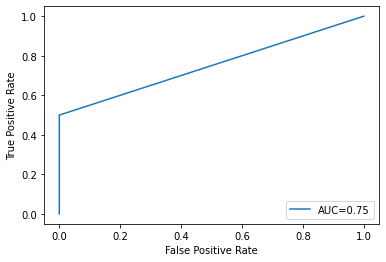

In [47]:
#roc curve
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(yn_test,  yn_pred)
auc = metrics.roc_auc_score(yn_test, yn_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

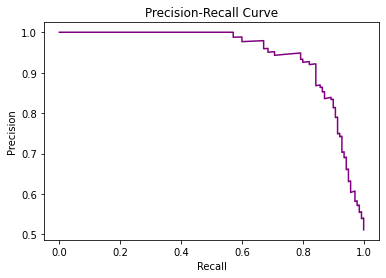

In [48]:
#Create PR Curve for Original Dataset
from sklearn.metrics import precision_recall_curve

yn_score = xgb.predict_proba(Xn_test)[:, 1]
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(yn_test, yn_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show() 

In [49]:
#Create Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

confusionMatrix = confusion_matrix(yn_test,yn_pred)
ConfusionMatrixDisplay(confusionMatrix).plot()

ImportError: ignored

feature selection

[0.         0.         0.         ... 0.01971301 0.         0.        ]


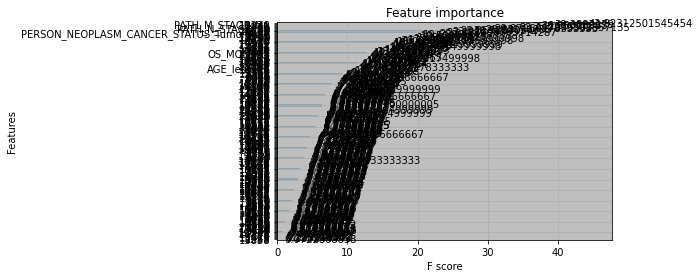

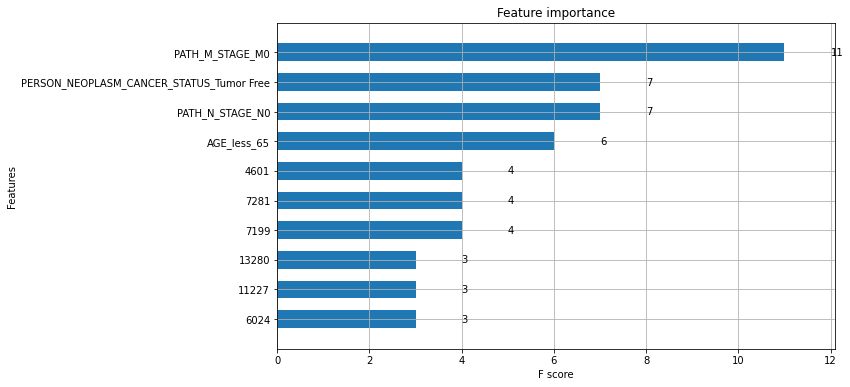

In [50]:
model_new = XGBClassifier(
learning_rate =0.1,
n_estimators=50,
max_depth=5,
min_child_weight=5,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
seed=42)

model_new.fit(Xn_train,yn_train)

from xgboost import plot_importance
print(model_new.feature_importances_)
plot_importance(model_new,importance_type='gain')

fig,ax = plt.subplots(figsize=(10,6))
plot_importance(model_new,
                height=0.6,
                ax = ax,
                max_num_features=10)
plt.show()

In [ ]:
def _feature_select(data, xgb_model, n):
    column_names = data.columns
    varlist = data[column_names[:20531]].columns 
    para_df = pd.DataFrame(varlist, columns=['parameter'])
    print(para_df)
    para_df['feature_importance'] = xgb_model.feature_importances_ 
    para_df = para_df.sort_values('feature_importance', ascending = False).reset_index(drop=True)
    top_var = list(para_df.loc[:n-1,]['parameter']) 
    return top_var

top30_var = _feature_select(Xn, model_new, 30) 
top30_var

In [ ]:
#Concat dataset with selected 30 important features
df_new = pd.concat([yn, Xn[top30_var]], axis=1)

X_af = df_new.drop(['OS_STATUS'], axis=1)
y_af = df_new['OS_STATUS']

df_new.head()

,OS_STATUS,PATH_M_STAGE_M0,10336,17041,1173,PATH_N_STAGE_N0,17822,5158,20195,8572,...,4510,4315,15575,15101,851,7281,4886,13086,10216,7337
0,0,1,-2.2020,-0.6202,-1.6860,1,-3.2473,-1.9321,0.9381,5.2098,...,2.1094,-0.0378,4.8332,2.7481,-1.1024,-0.7034,-0.2702,-4.7024,-1.5339,-0.6859
1,0,1,-4.6199,-1.8158,-0.5765,0,-6.1188,-0.6836,-2.8623,-0.4574,...,-2.2725,-1.6544,1.8333,1.7007,-5.6922,-0.7029,5.2375,-2.1513,-2.2127,-0.6855
2,0,0,-5.5004,-1.9792,-1.7857,1,-2.6241,-0.1959,-1.1739,1.8604,...,-0.7750,-0.9925,5.4687,0.8539,-6.7096,2.0843,1.4599,-2.9637,-1.8416,-1.8402
3,1,0,-4.1149,-2.8005,-0.5829,1,-5.2858,1.2351,-0.0814,6.5561,...,1.8872,-1.3165,-0.5609,1.7824,-2.5274,2.5016,1.0587,-3.7555,-3.1628,-1.2296
4,1,0,-5.5004,0.6557,-1.2667,0,-2.0539,3.5148,3.3210,4.0243,...,-2.8069,-0.1039,0.5399,2.8693,0.8468,0.9106,5.0154,-6.8576,0.6818,-1.8402


In [ ]:
#Re-split the dataset with selected 10 important features
train_x_af,test_x_af,train_y_af,test_y_af=train_test_split(X_af,y_af,test_size=0.33,random_state=123)

#fit the classifier to new training data
model_filtered = XGBClassifier(
learning_rate =0.1,
n_estimators=50,
max_depth=5,
min_child_weight=5,
gamma=0,
subsample=0.8,
colsample_bytree=0.8,
objective= 'binary:logistic',
nthread=4,
seed=42)

model_filtered.fit(train_x_af,train_y_af)

XGBClassifier(colsample_bytree=0.8, max_depth=5, min_child_weight=5,
              n_estimators=50, nthread=4, seed=42, subsample=0.8)

metrics

In [ ]:
# accuracy 
from sklearn.metrics import accuracy_score
yn_af_pred = model_filtered.predict(test_x_af)
predictions = [round(value) for value in yn_af_pred]
accuracy = accuracy_score(test_y_af, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 92.34%


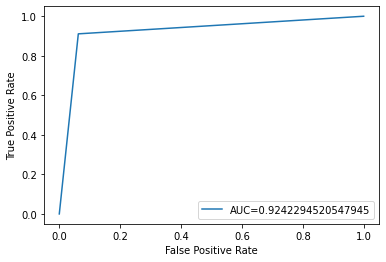

In [ ]:
#roc curve
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(test_y_af,  yn_af_pred)
auc = metrics.roc_auc_score(test_y_af, yn_af_pred)

plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

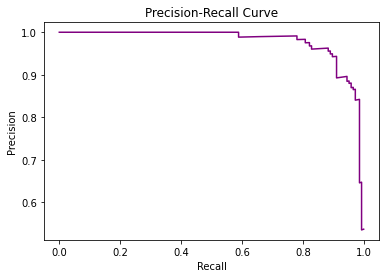

In [ ]:
#Create PR Curve for Original Dataset
from sklearn.metrics import precision_recall_curve

yn_af_score = model_filtered.predict_proba(test_x_af)[:, 1]
#calculate precision and recall
precision, recall, thresholds = precision_recall_curve(test_y_af, yn_af_score)

#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show() 

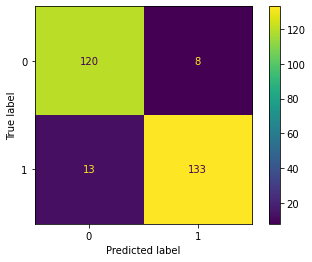

In [ ]:
#Create Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay

confusionMatrix = confusion_matrix(test_y_af,yn_af_pred)
ConfusionMatrixDisplay(confusionMatrix).plot()

In [ ]:
from sklearn import metrics
print('AUC: %.4f' % metrics.roc_auc_score(test_y_af,yn_af_pred))
print('ACC: %.4f' % metrics.accuracy_score(test_y_af,yn_af_pred))
print('Recall: %.4f' % metrics.recall_score(test_y_af,yn_af_pred))
print('F1-score: %.4f' %metrics.f1_score(test_y_af,yn_af_pred))
print('Precesion: %.4f' %metrics.precision_score(test_y_af,yn_af_pred))
metrics.confusion_matrix(test_y_af,yn_af_pred)

AUC: 0.9242
ACC: 0.9234
Recall: 0.9110
F1-score: 0.9268
Precesion: 0.9433


array([[120,   8],
       [ 13, 133]])